In [90]:
import pyspark
from pyspark import SparkContext
import time
  
sc = SparkContext.getOrCreate()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

In [92]:
#File location and type
path = r"C:\Users\anton\OneDrive\Documentos\Georgian\BDAT_1008_Data_Colection_Curation\Assignment1\covid-19.csv"
file_type = "csv"

# store starting time
start = time.time()

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# Import csv. The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(path)
end = time.time()
df.show(10) #first 10 rows

print(f"time taken: {end-start}")

+-------------------+-----------+----------------------+---------------+------------+-----------------------+----------------+
|               date|    country|cumulative_total_cases|daily_new_cases|active_cases|cumulative_total_deaths|daily_new_deaths|
+-------------------+-----------+----------------------+---------------+------------+-----------------------+----------------+
|2020-02-15 00:00:00|Afghanistan|                     0|           null|           0|                      0|            null|
|2020-02-16 00:00:00|Afghanistan|                     0|           null|           0|                      0|            null|
|2020-02-17 00:00:00|Afghanistan|                     0|           null|           0|                      0|            null|
|2020-02-18 00:00:00|Afghanistan|                     0|           null|           0|                      0|            null|
|2020-02-19 00:00:00|Afghanistan|                     0|           null|           0|                      0|  

In [4]:
df.describe().show()

+-------+-----------+----------------------+------------------+------------------+-----------------------+------------------+
|summary|    country|cumulative_total_cases|   daily_new_cases|      active_cases|cumulative_total_deaths|  daily_new_deaths|
+-------+-----------+----------------------+------------------+------------------+-----------------------+------------------+
|  count|     184787|                184787|            174329|            166747|                 178227|            157850|
|   mean|       null|     725108.8640434663|2987.6332853397885| 62392.82504632767|     13885.998125985401|  39.8318340196389|
| stddev|       null|    3681471.3613277255|  17803.2326631115|395564.13753319613|      60495.21047198392|181.10276967779444|
|    min|Afghanistan|                     0|              -322|            -14321|                      0|               -39|
|    max|   Zimbabwe|              84209473|            909610|          17935434|                1026646|            

In [5]:
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- country: string (nullable = true)
 |-- cumulative_total_cases: integer (nullable = true)
 |-- daily_new_cases: integer (nullable = true)
 |-- active_cases: integer (nullable = true)
 |-- cumulative_total_deaths: integer (nullable = true)
 |-- daily_new_deaths: integer (nullable = true)



In [6]:
df.createOrReplaceTempView("Covid19")

In [7]:
query = spark.sql("""select distinct country as cuenta from Covid19 group by cuenta order by cuenta asc""")
query.count()

226

In [19]:
#Top Ten countries by death rates
spark.sql("""select country, sum(daily_new_deaths) as total_deaths from Covid19 group by country order by sum(daily_new_deaths) desc limit 10""").show()

+---------+------------+
|  country|total_deaths|
+---------+------------+
|      USA|     1026646|
|   Brazil|      664920|
|    India|      524214|
|   Russia|      377571|
|   Mexico|      324463|
|     Peru|      213020|
|       UK|      176708|
|    Italy|      165182|
|Indonesia|      156453|
|   France|      147256|
+---------+------------+



In [9]:
#6. For the 10 countries indentified, plot the line charts to show the trend of deaths from Jan 22, 2020 to May 14, 2022
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import requests
requests.packages.urllib3.disable_warnings()

query = spark.sql("""select date, country, daily_new_deaths from Covid19 
                where country in ('USA', 'Brazil', 'India', 'Russia', 'Mexico', 'Peru', 'UK', 'Italy', 'Indonesia', 'France')
                and date between '2020-01-22' and '2022-05-14'""")

In [60]:
pddf = query.toPandas()
pivot = pd.pivot_table(pddf, values = "daily_new_deaths", index = "date", columns = "country")
pivot.reset_index(inplace = True)
pivot.columns

Index(['date', 'Brazil', 'France', 'India', 'Indonesia', 'Italy', 'Mexico',
       'Peru', 'Russia', 'UK', 'USA'],
      dtype='object', name='country')

In [17]:
#To generate the graph with plotly

fig = go.Figure(go.Scatter(x=pivot.index, y=pivot.Brazil))

fig.update_layout(title_text='Trend of deaths from jan 22/2020 to may 14/2022')

pio.write_html(fig, file='death_trends.html', auto_open=True)

Text(0, 0.5, 'Number of deaths')

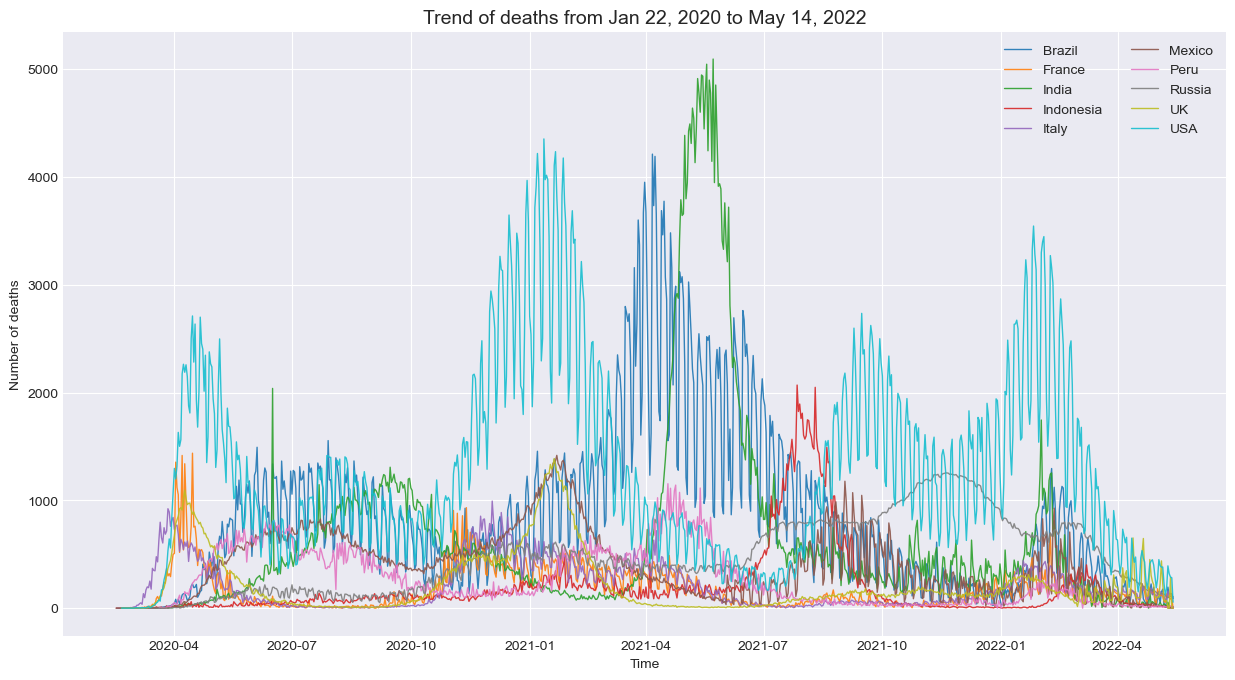

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100

# Plot the 10 countries
for column in pivot.drop('date', axis=1):
    plt.plot(pivot['date'], pivot[column], marker='', linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(ncol=2)
 
# Add titles
plt.title("Trend of deaths from Jan 22, 2020 to May 14, 2022", fontsize=14, fontweight=0)
plt.xlabel("Time")
plt.ylabel("Number of deaths")

In [98]:
#For each country and date, calculate cumulative recovered cases. Formula: cumulative recovered cases = cumulative_total_cases - active_cases - cumulative_total_deaths.

ndf = df.withColumn("cumulative_recovered_cases", df.cumulative_total_cases-df.active_cases-df.cumulative_total_deaths)

ndf.createOrReplaceTempView("Covid19")
recovered = spark.sql("""select country, max(cumulative_recovered_cases) as recovered from Covid19 group by country order by recovered desc limit 10""")
recovered.show()

+-------+---------+
|country|recovered|
+-------+---------+
|    USA| 81244260|
|  India| 42579693|
| Brazil| 29718402|
| France| 28156674|
|Germany| 23925400|
|     UK| 21657770|
| Russia| 17640979|
|  Italy| 15864177|
| Turkey| 14951238|
|  Spain| 11548089|
+-------+---------+



In [103]:
#8. Plot the trend of the recovery rate (cumulative recovered cases / cumulative_total_cases) for the period Jan 22, 2020 to May 14, 2022. 
# Your horizontal axis should be the date. Which 5 countries have a relatively higher recovery rate

ndf = ndf.withColumn("recovery_rate", ndf.cumulative_recovered_cases/ndf.cumulative_total_cases)

ndf.createOrReplaceTempView("Covid19")

recrate = spark.sql("""select country, mean(recovery_rate) from Covid19 group by country order by mean(recovery_rate) desc limit 10""")
recrate.show()

#ndf.createOrReplaceTempView("Covid19")
#death = spark.sql("""select country, sum(daily_new_deaths) as total_deaths from Covid19 group by country order by sum(daily_new_deaths) desc limit 10""").show()
#recovery = spark.sql("""select date, country, daily_new_deaths from Covid19 
#                where country in ('USA', 'Brazil', 'India', 'Russia', 'Mexico', 'Peru', 'UK', 'Italy', 'Indonesia', 'France')
#                and date between '2020-01-22' and '2022-05-14'""")

+----------+-------------------+
|   country|mean(recovery_rate)|
+----------+-------------------+
|Tajikistan| 0.9166730702420742|
|    Turkey| 0.9028839202788369|
|  Djibouti| 0.9008059832195238|
|  Anguilla| 0.8992468296079924|
| Gibraltar| 0.8988634120500265|
|     China| 0.8919412071805985|
|Kyrgyzstan| 0.8884551006976696|
|Uzbekistan| 0.8804863256434565|
|   Comoros| 0.8798051574981837|
|   Bahrain| 0.8788358314233675|
+----------+-------------------+

